# Analysis of the performance of our method

In [53]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy.stats as st
from sklearn.cluster import KMeans
from tqdm import tqdm

def get_model(params):
    if np.random.rand() < params['CONST_VEL_MODEL_PROB']:
        return 'CONST_VEL'
    else:
        return 'CONST_VEL_W_ROTATION'
    
def get_action(params):
    if np.random.rand() < params['STOP_PROB']:
        return 'STOP'
    if np.random.rand() < params['VELOCITY_CHANGE_PROB']:
        return 'VELOCITY_CHANGE'
    if np.random.rand() < params['ANGLE_CHANGE_PROB']:
        return 'ANGLE_CHANGE'
    return None

# Decide whether to use average or discounted average as const velocity
def get_const_vel(params, sample_vel_x, sample_vel_y):
    if np.random.rand() < params['DISCOUNT_AVG_PROB']:
        discount = np.random.uniform(low=params['DISCOUNT_LOWER_BOUND'])
        const_vel_x = (discount**3*sample_vel_x[0] + discount**2*sample_vel_x[1] + discount*sample_vel_x[2] + sample_vel_x[3]) / (discount**3 + discount**2 + discount + 1)
        const_vel_y = (discount**3*sample_vel_y[0] + discount**2*sample_vel_y[1] + discount*sample_vel_y[2] + sample_vel_y[3]) / (discount**3 + discount**2 + discount + 1)
    else:
        const_vel_x = np.mean(sample_vel_x)
        const_vel_y = np.mean(sample_vel_y)
        
    return const_vel_x, const_vel_y

# Decide whether to use average or discounted average angle
def get_angle(params, sample_vel_x, sample_vel_y):
    all_angles = []
    for i in range(1, len(sample_vel_x)):
        prev_vel = [sample_vel_x[i-1], sample_vel_y[i-1]]
        curr_vel = [sample_vel_x[i], sample_vel_y[i]]
        one_angle = np.math.atan2(np.linalg.det([prev_vel, curr_vel]),np.dot(prev_vel, curr_vel))   
        all_angles.append(one_angle)
    
    if np.random.rand() < params['DISCOUNT_AVG_PROB']:
        discount = np.random.uniform(low=params['DISCOUNT_LOWER_BOUND'])
        angle = (discount**2*all_angles[0] + discount*all_angles[1] + all_angles[2]) / (discount**2 + discount + 1)
    else:
        angle = np.mean(all_angles)
    return angle

def calculate_FDE(pred_x, pred_y, test_x, test_y):

    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    return FDE

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def generate_trajectory(sample_x, sample_y, params, length=5):
    # calculate velocity data
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, params['NOISE']) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, params['NOISE']) for i in range(1, len(sample_y))]
    
    const_vel_x, const_vel_y = get_const_vel(params, sample_vel_x, sample_vel_y)
    angle = get_angle(params, sample_vel_x, sample_vel_y)
    
    # start predicting
    pred_x = []
    pred_y = []
    model = get_model(params)
    for i in range(length):
        action = get_action(params)
        if action == 'STOP':
            if len(pred_x) == 0:
                pred_x.append(sample_x[-1])
                pred_y.append(sample_y[-1])
            else:
                pred_x.append(pred_x[-1])
                pred_y.append(pred_y[-1])
            continue
            
        elif action == 'VELOCITY_CHANGE':
            const_vel_x = const_vel_x + np.random.normal(0, params['VELOCITY_CHANGE_NOISE'])
            const_vel_y = const_vel_y + np.random.normal(0, params['VELOCITY_CHANGE_NOISE'])
        elif action == 'ANGLE_CHANGE':
            angle = angle + np.random.normal(0, params['ANGLE_CHANGE_NOISE'])
        
        if model == 'CONST_VEL':
            if len(pred_x) == 0:
                pred_x.append(sample_x[-1] + const_vel_x)
                pred_y.append(sample_y[-1] + const_vel_y)
            else:
                pred_x.append(pred_x[-1] + const_vel_x)
                pred_y.append(pred_y[-1] + const_vel_y)
        elif model == 'CONST_VEL_W_ROTATION':
            if len(pred_x) == 0:
                prev_x = sample_x[-2]
                prev_y = sample_y[-2]
                cur_x = sample_x[-1] + const_vel_x
                cur_y = sample_y[-1] + const_vel_y
            else:
                prev_x = pred_x[-1]
                prev_y = pred_y[-1]
                cur_x = pred_x[-1] + const_vel_x
                cur_y = pred_y[-1] + const_vel_y
            rot_x, rot_y = rotate((prev_x, prev_y), (cur_x, cur_y), angle)
            pred_x.append(rot_x)
            pred_y.append(rot_y)
            
            # redefine the average velocity as it now has a new heading
            const_vel_x = rot_x - prev_x
            const_vel_y = rot_y - prev_y
        
    return pred_x, pred_y
            
def run_KMeans(pred_x_list, pred_y_list, no_of_clusters):
    final_points = []
    # this can be optimized as this is done in the parent method already
    for i in range(len(pred_x_list)):
        final_points.append([pred_x_list[i][-1], pred_y_list[i][-1]])
    
    Kmean = KMeans(n_clusters=no_of_clusters)
    Kmean.fit(final_points)

    cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster = get_clustered_averages(pred_x_list, pred_y_list, no_of_clusters, Kmean.labels_)
    # Should probably also return labels or do the averaged clusters already contain them?
    return cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster

def get_clustered_averages(all_pred_x, all_pred_y, no_of_clusters, cluster_labels):
    no_of_elements_per_cluster = []
    for i in range(no_of_clusters):
        no_of_elements_per_cluster.append((cluster_labels == i).sum())
    
    clustered_preds_x = [[] for _ in range(no_of_clusters)]
    clustered_preds_y = [[] for _ in range(no_of_clusters)]

    for idx, cluster_label in enumerate(cluster_labels):
        clustered_preds_x[cluster_label].append(all_pred_x[idx])
        clustered_preds_y[cluster_label].append(all_pred_y[idx])
        
    cluster_avg_x = [[] for _ in range(no_of_clusters)]
    cluster_avg_y = [[] for _ in range(no_of_clusters)]
    
    for i in range(no_of_clusters):
        cluster_avg_x[i] = np.mean(clustered_preds_x[i], axis=0)
        cluster_avg_y[i] = np.mean(clustered_preds_y[i], axis=0)
        
    return cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster

def predict(sample_x, sample_y, params, trajectory_length=5):
    all_pred_x, all_pred_y = [], []
    all_final_x, all_final_y = [], []
    
    for i in range(params['NO_OF_TRAJECTORIES']):
        pred_x, pred_y = generate_trajectory(sample_x, sample_y, params, trajectory_length)
        all_pred_x.append(pred_x)
        all_pred_y.append(pred_y)
        
        all_final_x.append(pred_x[-1])
        all_final_y.append(pred_y[-1])
    
    # run kernel density estimate
    values = np.vstack([all_final_x, all_final_y])
    kernel = st.gaussian_kde(values)
    # evaluate trajectories
    evaluated = kernel.evaluate(values)
    # find the sorting order for the trajectories based on KDE pdf
    sorting_order = evaluated.argsort()[::-1] # Note: the sorting order is ascending by default, [::-1] reverses the order (might be too slow though?)
    
    # sort predictions by KDE density
    sorted_all_pred_x = np.array(all_pred_x)[sorting_order]
    sorted_all_pred_y = np.array(all_pred_y)[sorting_order]
    
    # distribute the data to representative sets
    no_of_traj = len(sorted_all_pred_x)

    
    # find the closest TOP% (first cluster size) of trajectories for the highest density trajectory
    highest_density_x = sorted_all_pred_x[0]
    highest_density_y = sorted_all_pred_y[0]
    largest_distance = None
    closest_indexes = np.array([], dtype=np.int8)
    closest_distances = np.array([])
    
    for idx in range(len(sorted_all_pred_x)):
        distance = calculate_FDE(highest_density_x, highest_density_y, sorted_all_pred_x[idx], sorted_all_pred_y[idx])
        
        if len(closest_indexes) < no_of_traj*params['GROUP_PERCENTAGES'][0]:
            closest_indexes = np.append(closest_indexes, idx)
            closest_distances = np.append(closest_distances, distance)
            if largest_distance == None or largest_distance < distance:
                largest_distance = distance
        else:
            if largest_distance > distance:
                index_max = np.argmax(closest_distances)
                closest_indexes[index_max] = idx
                closest_distances[index_max] = distance
                largest_distance = np.amax(closest_distances)
    
    closest_x = sorted_all_pred_x[closest_indexes]
    closest_y = sorted_all_pred_y[closest_indexes]

    # remove the closest trajectories from the data...
    sorted_all_pred_x = np.delete(sorted_all_pred_x, closest_indexes, axis=0)
    sorted_all_pred_y = np.delete(sorted_all_pred_y, closest_indexes, axis=0)
    
    # ...and move them to the front of the array
    sorted_all_pred_x = np.append(closest_x, sorted_all_pred_x, axis=0)
    sorted_all_pred_y = np.append(closest_y, sorted_all_pred_y, axis=0)
    
    # Return values will be in a format of [pred_xs: list, pred_ys: list, pred_weigths: list]
    return_values = [[], [], []]
    
    
    ## Loop over the representative groups and run K-means clustering on each
    ## (if group should return more than 1 representative trajectory)
    
    prev_group_size_end = 0
    group_size_ends = params['GROUP_PERCENTAGES']
    for group_idx, group_size_end in enumerate(group_size_ends):
        group_cluster_count = params['GROUP_CLUSTER_COUNT'][group_idx]
        
        group_x = sorted_all_pred_x[int(no_of_traj*prev_group_size_end):int(no_of_traj*group_size_end)]
        group_y = sorted_all_pred_y[int(no_of_traj*prev_group_size_end):int(no_of_traj*group_size_end)]
        
        # No need to run k-means clustering if the group is supposed to have just 1 representative cluster
        if group_cluster_count == 1:
            representative_x = np.mean(group_x, axis=0)
            representative_y = np.mean(group_y, axis=0)
            trajectory_weight = len(representative_x)/no_of_traj
            
            return_values[0].append(representative_x)
            return_values[1].append(representative_y)
            return_values[2].append(trajectory_weight)
        else:
            group_data = run_KMeans(group_x, group_y, no_of_clusters=group_cluster_count)
            group_pred_xs, group_pred_ys, group_no_of_trajs = group_data
            
            return_values[0] = return_values[0] + [*group_pred_xs]
            return_values[1] = return_values[1] + [*group_pred_ys]
            return_values[2] = return_values[2] + [*[i/no_of_traj for i in group_no_of_trajs]]
        
        prev_group_size_end = group_size_end
   
    # Return (all_x_predictions, all_y_predictions, all_weights)
    return return_values
    

In [6]:
from data_processing import read_edinburgh_data 
edinburgh_data, edinburgh_agent_ids = read_edinburgh_data()

from data_processing import read_UCY_data
ucy_data, ucy_agent_ids = read_UCY_data()

from data_processing import read_HERMES_data
hermes_data, hermes_agent_ids = read_HERMES_data(sampling_rate=1)

from data_processing import read_eth_data
eth_data, eth_agent_ids = read_eth_data(sampling_rate=1)

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|██████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:02<00:00, 37.21it/s]


Warning! too big dt in [Edinburgh]
finish


In [17]:
def agent_data(data, agent_id):
    x = data["pos_x"].loc[data["agent_id"]==agent_id].values
    y = data["pos_y"].loc[data["agent_id"]==agent_id].values

    max_train_idx = len(x)-10
    
    return x, y, max_train_idx

# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y
    
def calculate_FDE(pred_x, pred_y, test_x, test_y):

    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    return FDE

def calculate_ADE(pred_x, pred_y, test_x, test_y):
    total_displacement_error = 0
    for point_idx in range(len(test_x)):
        displacement_error = np.sqrt((pred_x[point_idx] - test_x[point_idx])**2 + (pred_y[point_idx] - test_y[point_idx])**2)
        total_displacement_error += displacement_error

    return total_displacement_error/len(pred_x)

def evaluate_trajectory(sample_x, sample_y, test_x, test_y, params, metric='FDE'):
    pred_xs, pred_ys, pred_ws = predict(sample_x, sample_y, params, trajectory_length=6)
    all_errors = []
    for i in range(len(pred_xs)):
        pred_x = pred_xs[i]
        pred_y = pred_ys[i]
        #weight = pred_ws[i]
        
        if metric == 'ADE':
            error = calculate_ADE(pred_x, pred_y, test_x, test_y)
        elif metric == 'FDE':
            error = calculate_FDE(pred_x, pred_y, test_x, test_y)
        else:
            assert False
        all_errors.append(error)
        
    # Find out which trajectory was the best
    index_min_error = np.argmin(all_errors)
    return min(all_errors), index_min_error

def evaluate_on_dataset(data, agent_ids, params, metric='FDE'):
    all_errors = []
    best_trajectory_indexes = []
    for agent_id in tqdm(agent_ids):
        x_data, y_data, max_train_idx = agent_data(data, agent_id)

        #for i in range(0, min(5, max_train_idx+1)):
        for i in range(0, 1):
            start_idx = i

            sample_x, sample_y, test_x, test_y = generate_data(data, start_idx, agent_id, 6)
            min_error, best_traj_index = evaluate_trajectory(sample_x, sample_y, test_x, test_y, params, metric=metric)
            all_errors.append(min_error)
            best_trajectory_indexes.append(best_traj_index)

    return np.mean(all_errors), best_trajectory_indexes


In [27]:
params = {
    "NOISE": 0.05,
    "NO_OF_TRAJECTORIES": 1000,
    "CONST_VEL_MODEL_PROB": 0.8,

    "STOP_PROB": 0.05,

    "DISCOUNT_AVG_PROB": 0.5,
    "DISCOUNT_LOWER_BOUND": 0.5,

    "VELOCITY_CHANGE_PROB": 0.2,
    "VELOCITY_CHANGE_NOISE": 0.1,

    "ANGLE_CHANGE_PROB": 0.2,
    "ANGLE_CHANGE_NOISE": 1,

    "GROUP_PERCENTAGES": [0.15, 0.68, 0.95, 1.0],
    "GROUP_CLUSTER_COUNT": [1, 7, 7, 5] # Total 20 traj
}

In [54]:
edinburgh_res, edinburgh_best_traj_indexes = evaluate_on_dataset(edinburgh_data, edinburgh_agent_ids, params)
ucy_res, ucy_best_traj_indexes = evaluate_on_dataset(ucy_data, ucy_agent_ids, params)
hermes_res, hermes_best_traj_indexes = evaluate_on_dataset(hermes_data, hermes_agent_ids, params)
eth_res, eth_best_traj_indexes = evaluate_on_dataset(eth_data, eth_agent_ids, params)

100%|████████████████████████████████████████████████████████████████████████████████████| 337/337 [00:42<00:00,  7.99it/s]


0.6695979211876047


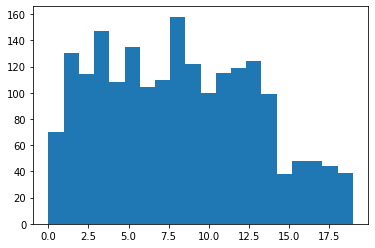

In [55]:
plt.hist(edinburgh_best_traj_indexes, bins=20)
print(edinburgh_res)

0.22758862335736094


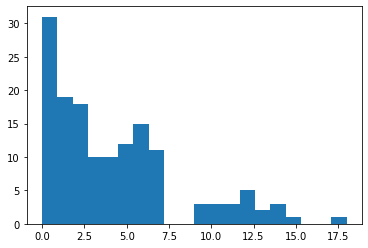

In [56]:
plt.hist(ucy_best_traj_indexes, bins=20)
print(ucy_res)

0.08608992788640019


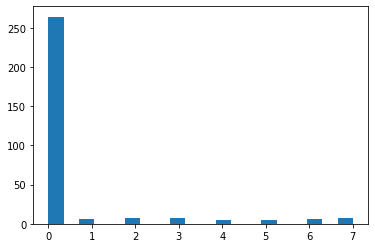

In [57]:
plt.hist(hermes_best_traj_indexes, bins=20)
print(hermes_res)

0.25466287679583316


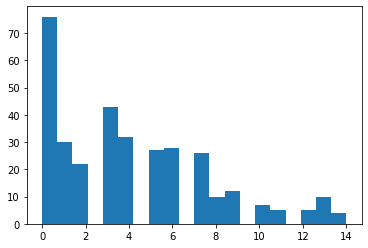

In [58]:
plt.hist(eth_best_traj_indexes, bins=20)
print(eth_res)